In [1]:
# https://www.ohmsha.co.jp/book/9784274226984/
# bayes
%config IPCompleter.greedy=True
import sys
import numpy as np
import scipy as sp
import scipy.stats
import sympy as symp
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

# ベイズの定理
```
P(Xi|Y) = P(Y|Xi)P(Xi) / Σ P(Y|Xi)P(Xi) : 事後確率 = 尤度 * 事前確率 / 周辺尤度
```

> 留意されたい...母集団を恣意的に変えることができる...２回目の検査では検査を受けた人を母集団に...この変更の妥当性に注意を払う必要がある。
> 初めの事前確率があたかも求まっているという前提で話を進めている。しかし、...用いた事前確率の信頼性に注意を払う必要がある。

# 確率分布のベイズ推定
```
観測値Y(未知の確率分布に従うデータ)から、未知の確率分布のパラメータの分布を推定する
P(Θ|Y) = P(Y|Θ)P(Θ) / P(Y) ∝ P(Y|Θ)P(Θ)
```

In [2]:
# 5回の試行で３回成功したとする
# 二項分布のパラメータpの分布を推定する
import sympy
p = sympy.Symbol('p')
likelihood = p**3 * (1-p)**2
const = sympy.integrate(likelihood, (p, 0, 1))
const # 正規化定数

1/60

In [3]:
pos_1 = likelihood/const # 事後分布
all_prob = sympy.integrate(pos_1, (p,0,1))
all_prob # 正規化したので積分=１になる（確率となる

1

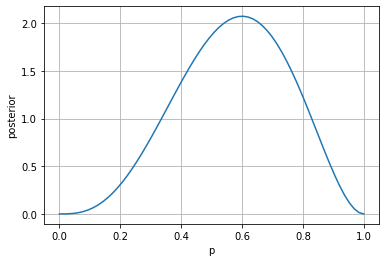

In [4]:
prob = np.linspace(0, 1, 64)
dense = [pos_1.subs(p, i) for i in prob] # subsでpに対する密度を求める
plt.plot(prob, dense)
plt.xlabel('p')
plt.ylabel('posterior')
plt.grid()

In [5]:
# 推定した事後分布から点推定する
## MAP推定(maximum a posterior estimation)
maxidx = np.argmax(dense) # denseを最大化する引数＝dense配列のうち最大を取るインデックス
prob[maxidx]

0.6031746031746031

In [6]:
##事後分布の平均値
mean_val = sympy.integrate(p * pos_1, (p,0,1))
float(mean_val)

0.5714285714285714

In [7]:
# メトロポリス法
import math

# 目標分布
def f(x):
    return 1 / math.sqrt(2*math.pi)*math.exp(-x**2/2)

n = 512
skip = 10 # > その前後のサンプルと非常に強い相関があるため、独立性を求めるために間引いてサンプル系列を得る
theta = 10 # 初期値
samples = np.zeros(n)
for k in range(n * skip):
    # 提案分布（次に移動する点を提案する。ここでは一様分布）から値を取る
    xi = sp.stats.uniform.rvs(loc=-1, scale=2, size=1) # -1 ~ 1
    # Θnew = Θ + xi
    theta_new = theta + xi
    # これを、f(Θnew) / f(Θ) の確率で採択する（状態遷移と棄却法を組み合わせ）
    # > Θが遷移する様子はマルコフ連鎖的であり(直前のΘにのみ依存する)
    # > 乱数を発生させて採択条件を定めていることはモンテカルロ法
    p = min(1, f(theta_new)/f(theta) )
    if np.random.rand() < p:
        theta = theta_new
    # 目標分布から直接サンプリングが出来ないので、
    # 移動したΘの系列データから抽出したものを、目標分布からサンプリングしたものと見做す
    if k % skip == 0:
        samples[k // skip] = theta

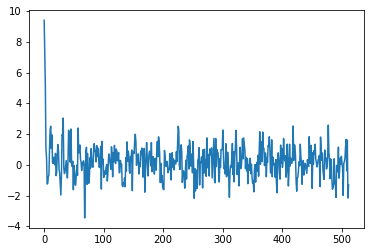

In [8]:
plt.plot(samples)

In [9]:
## カーネル密度推定（KDE）
kde = sp.stats.gaussian_kde(samples[100:]) # burn in を捨てる

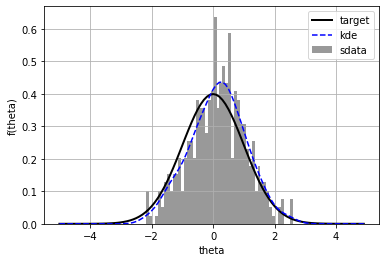

In [10]:
X = np.arange(-5, 5, 0.1)
Y = sp.stats.norm.pdf(X, 0.0, 1.0)

plt.plot(X, Y, linewidth=2, color='k', label='target') # 目標分布
plt.hist(samples[100:], bins=50, density=True, color=(0.6, 0.6, 0.6), label='sdata') # サンプル系列
plt.plot(X, kde(X), linestyle='dashed', color='b', label='kde') # サンプル系列からKDEでフィット
plt.xlabel('theta')
plt.ylabel('f(theta)')
plt.legend()
plt.grid(True)

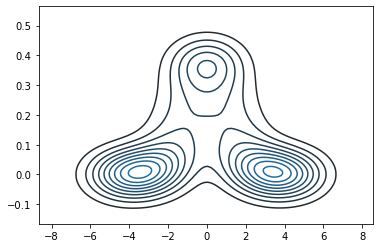

In [11]:
sns.kdeplot(X, Y)

# MCMC
サンプリング手法の１つ（棄却法、逆関数法etc）
> 事後分布の形状を直接求めるのが難しいとき...分布に沿ったランダムなサンプルを生成し...事後分布を推定する方法の１つ

MCMCのサンプラー
+ バイナリ変数 : BinaryMetropolis
+ 離散変数 : Metropolis-Hastings
+ 連続変数 : NUTS

In [12]:
# pymc3 3.8 との互換性のためarvizは0.11.0とする
# https://discourse.pymc.io/t/attributeerror-module-arviz-has-no-attribute-geweke/6818
# > conda install -c conda-forge arviz=0.11.0
import pymc3 as pm

n=100 # 試行回数
truth=0.35 # 真の成功率
y=sp.stats.bernoulli.rvs(p=truth, size=n) # 観測データ
succeed=y.sum() # 観測した成功回数

with pm.Model() as model:
    # > 複数ある候補の中から無情報事前分布であるβ(1,1)を与える
    theta = pm.Beta('theta', alpha=1, beta=1) # β(1, 1) = uniform
    # 目標分布は二項分布とする
    y_rv = pm.Binomial('y_rv', n=n, p=theta, observed=succeed)

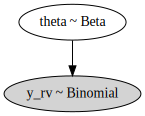

In [13]:
pm.model_to_graphviz(model)

In [14]:
with model:
    start = pm.find_MAP() # サンプリングの出発点候補。省略しても良い
    step = pm.Metropolis() # サンプリング法
    trace = pm.sample(draws=1000,tune=100,start=start,step=step,cores=4)

logp = -5.9153, ||grad|| = 13: 100%|██████████| 7/7 [00:00<00:00, 377.88it/s]
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 4400/4400 [00:03<00:00, 1395.73draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CA80125C10>,
      dtype=object)

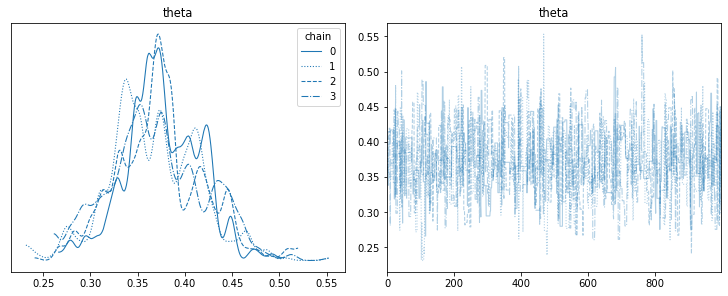

In [16]:
pm.traceplot(trace,figsize=(10,4),legend=True)
# > 分布図を見て留意してほしい...従来の確率・統計論は、分布はある関数の枠にはめて論じる流儀であった。
# > しかし、ベイズ統計は、現実の分布の形状はいびつで変形しており...このようないびつな分布をどう評価するか、ということもユーザに問いかけている

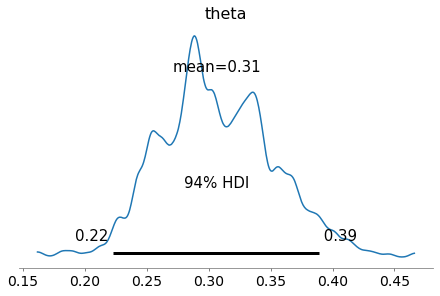

In [13]:
pm.plot_posterior(trace)
# 得られた事後分布

In [14]:
pm.summary(trace)
# サンプル系列間分散が小さくなれば、r_hatは１に近づく...実用的にはr_hat < 1.1が収束の目安
# > essは、分母に自己相関関数の値を含むため、自己相関が小さいほど大きな値を取る。
# > mcseは...いわゆる標準誤差のマルコフ連鎖版と言え、この値が小さいほどサンプル系列の性質は良いとされる。
# > ...どのくらいの値が良いかはサンプル数などに依存する...

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.307,0.046,0.223,0.389,0.002,0.001,693.0,691.0,698.0,783.0,1.01
